In [130]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from docplex.mp.advmodel import AdvModel
from matplotlib import style
import math
#style.use('dark_background') #si ton vs-code est noir

À faire:

- chercher les 30 peaks annuels => DONE
- aggreger la puissance installée + utiliser les coûts de PV => DONE
- commencer à implémenter le modèle

# Data preparation

In [131]:
data_2013 = pd.read_csv("./data/2012-2013 Solar home electricity data v2.csv", header = 1)

In [132]:
data_2013

,Customer,Generator Capacity,Postcode,Consumption Category,date,0:30,1:00,1:30,2:00,2:30,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00,Row Quality
0,1,3.78,2076,CL,1/07/2012,1.250,1.250,1.250,1.263,0.131,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.081,NaN
1,1,3.78,2076,GC,1/07/2012,0.855,0.786,0.604,0.544,0.597,...,0.374,0.447,0.549,0.136,0.288,0.181,0.651,0.090,0.068,NaN
2,1,3.78,2076,GG,1/07/2012,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
3,1,3.78,2076,CL,2/07/2012,1.250,1.250,1.125,0.000,0.925,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.069,NaN
4,1,3.78,2076,GC,2/07/2012,0.309,0.082,0.059,0.097,0.290,...,0.353,0.464,0.229,0.811,0.222,0.306,1.034,0.136,0.067,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268552,300,3.36,2086,GC,29/06/2013,0.171,0.832,0.440,0.745,0.149,...,0.383,0.404,0.367,0.398,0.350,0.228,0.170,0.139,0.171,NaN
268553,300,3.36,2086,GG,29/06/2013,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
268554,300,3.36,2086,CL,30/06/2013,2.501,2.475,2.491,2.508,2.490,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.468,NaN
268555,300,3.36,2086,GC,30/06/2013,0.150,0.158,0.157,0.137,0.163,...,0.625,0.595,0.695,0.646,0.581,0.458,0.472,0.732,0.297,NaN


In [133]:
#count the number of NA (non-actual) in 'Row Quality' column:
print(f"number of NA (non-actual) row: {data_2013['Row Quality'].count()}")

number of NA (non-actual) row: 0


In [134]:
#store customer infos
data_cust = data_2013.groupby(by='Customer')
cust_info = pd.DataFrame()
cust_info['Customer ID'] = data_cust['Customer'].first()
cust_info['Generator Capacity'] = data_cust['Generator Capacity'].first()
cust_info['Postcode'] = data_cust['Postcode'].first()

In [135]:
P_pv_installed = sum(cust_info['Generator Capacity'])
P_pv_installed

504.9899999999998

In [136]:
#rearrange dataframe
meltdate = data_2013.melt(id_vars = ['Customer', 'Consumption Category', 'date'], value_vars = data_2013.columns[5:53], var_name = 'time', value_name = 'power')
unstk = meltdate.pivot_table('power', ['Customer', 'date', "time"], 'Consumption Category')
unstk.reset_index(level = [0, 1, 2], inplace = True)
unstk['Timestamp'] = pd.to_datetime(unstk['date'] + unstk['time'], format='%d/%m/%Y%H:%M')
unstk.pop('date')
unstk.pop('time')

0           0:00
1           0:30
2          10:00
3          10:30
4          11:00
           ...  
5252107     7:30
5252108     8:00
5252109     8:30
5252110     9:00
5252111     9:30
Name: time, Length: 5252112, dtype: object

In [137]:
df = unstk.groupby(by = 'Timestamp').sum()
df = df.resample('60min').sum()
df.reset_index(inplace=True)
df.pop('Customer')
df['NET'] = df['GC'] + df['CL'] - df['GG']
df['TOTAL'] = df['GC'] + df['CL']
df

Consumption Category,Timestamp,CL,GC,GG,NET,TOTAL
0,2012-07-01 00:00:00,181.636,186.140,0.039,367.737,367.776
1,2012-07-01 01:00:00,152.692,151.654,0.076,304.270,304.346
2,2012-07-01 02:00:00,96.712,129.242,0.112,225.842,225.954
3,2012-07-01 03:00:00,44.895,125.389,0.291,169.993,170.284
4,2012-07-01 04:00:00,19.457,118.000,0.202,137.255,137.457
...,...,...,...,...,...,...
8755,2013-06-30 19:00:00,4.895,402.192,0.037,407.050,407.087
8756,2013-06-30 20:00:00,7.563,378.843,0.046,386.360,386.406
8757,2013-06-30 21:00:00,8.716,342.074,0.049,350.741,350.790
8758,2013-06-30 22:00:00,40.530,300.159,0.027,340.662,340.689


# Data visualization:

## Load profiles

Two letter code each meaning the following:

GC = General Consumption for electricity supplied all the time
(primary tariff, either inclining block or time of use rates),
excluding solar generation and controlled load supply

CL = Controlled Load Consumption (Off peak 1 or 2 tariffs)

GG = Gross Generation for electricity generated by the solar
system with a gross metering configuration, measured separately
to household loads

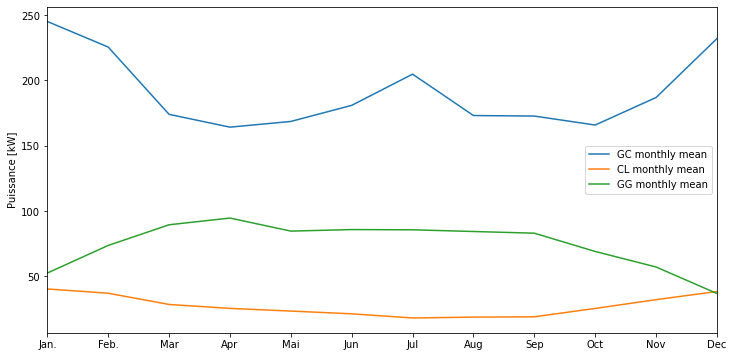

In [138]:
def plot_months(df):
    groupby_month = df.groupby(pd.Grouper(key='Timestamp', freq='M'))
    data_month = [group for _,group in groupby_month]
    GC_month, CL_month, GG_month = list(), list(), list()
    for month in data_month:
        GC_month.append(month['GC'].mean())
        CL_month.append(month['CL'].mean())
        GG_month.append(month['GG'].mean())

    fig = plt.figure(figsize=(12,6))
    lin = np.linspace(0, 12, 12)
    plt.plot(lin, GC_month, label = 'GC monthly mean')
    plt.plot(lin, CL_month, label = 'CL monthly mean')
    plt.plot(lin, GG_month, label = 'GG monthly mean')

    plt.legend()
    plt.xlim([0, 12])
    plt.xticks(lin, ['Jan.', 'Feb.', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.ylabel('Puissance [kW]')
    plt.show()

plot_months(df)

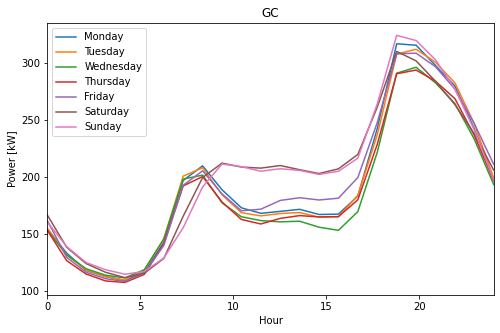

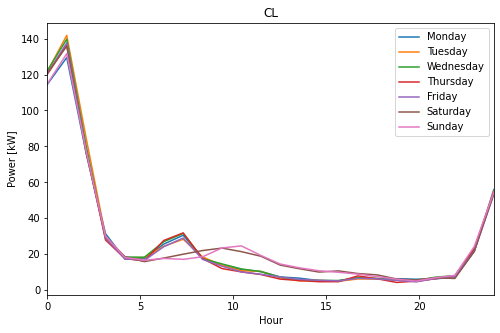

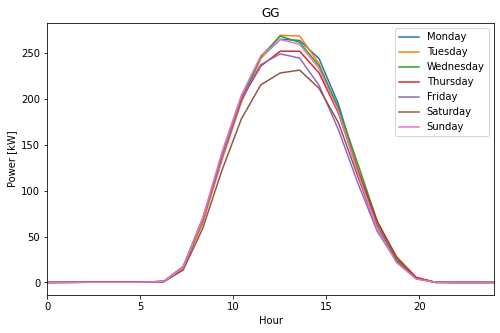

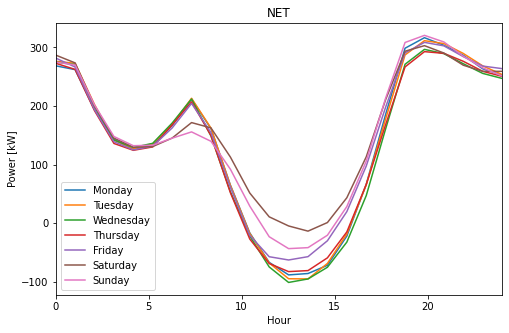

In [139]:
def plot_week(df, profil = 'GC'):
    #analysis per day
    day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    #seasons_name = ['Winter', 'Summer', 'Interseason']
    fig = plt.figure(figsize=(8, 5))
    data_day = df.groupby(df['Timestamp'].dt.weekday)
    list_day = [day for (_, day) in data_day]
    for i, day in enumerate(list_day):
        data_hour = day.groupby(day['Timestamp'].dt.hour).mean()
        if profil in ['GC', 'CL', 'GG', 'NET']:
            power_half = data_hour[profil]
        else:
            print("Wrong profil")
            return
        plt.plot(np.linspace(0, 24, 24), power_half, label = day_of_week[i])
    plt.xlim([0, 24])
    plt.xlabel('Hour')
    plt.ylabel('Power [kW]')
    plt.legend(loc = 0)
    plt.title(profil)
    plt.savefig(f"week_trend_{profil}")
    plt.show()

plot_week(df, 'GC')
plot_week(df, 'CL')
plot_week(df, 'GG')
plot_week(df, 'NET')

In [140]:
#peaks in year:
#df_sort = df.sort_values(by = 'NET', ascending = False)
#df_sort.reset_index(inplace=True)
#peak_dates = []
#peak_idx = [] #10 dates with biggest peaks
#n_peak_day = 30
#i = 0
#while len(peak_dates) < n_peak_day:
#    date = df_sort['Timestamp'].iloc[i].date()
#    if not date in peak_dates:
#        peak_dates.append(date)
#        peak_idx.append(i)
#df_peak = pd.DataFrame([df_sort.iloc[i] for i in peak_idx])

In [141]:
df_maxcons = df.CL.groupby(df.index//24).sum()/24

df['AVERAGE_CONTROLABLE_LOAD'] = np.repeat(df_maxcons.values, 24, axis=0)
df['BASELINE'] = df['GC'] + np.repeat(df_maxcons.values, 24, axis=0)
daily_CL = df_maxcons*24
daily_CL

0       989.382
1       906.019
2      1007.864
3       979.606
4       968.168
         ...   
360     994.940
361     989.718
362    1030.334
363    1070.919
364     983.622
Name: CL, Length: 365, dtype: float64

In [142]:
df_max = df.CL.groupby(df.index//24).max()
df['MAX_CONTROLABLE_LOAD'] = np.repeat(df_max.values, 24, axis=0)
df

Consumption Category,Timestamp,CL,GC,GG,NET,TOTAL,AVERAGE_CONTROLABLE_LOAD,BASELINE,MAX_CONTROLABLE_LOAD
0,2012-07-01 00:00:00,181.636,186.140,0.039,367.737,367.776,41.22425,227.36425,181.636
1,2012-07-01 01:00:00,152.692,151.654,0.076,304.270,304.346,41.22425,192.87825,181.636
2,2012-07-01 02:00:00,96.712,129.242,0.112,225.842,225.954,41.22425,170.46625,181.636
3,2012-07-01 03:00:00,44.895,125.389,0.291,169.993,170.284,41.22425,166.61325,181.636
4,2012-07-01 04:00:00,19.457,118.000,0.202,137.255,137.457,41.22425,159.22425,181.636
...,...,...,...,...,...,...,...,...,...
8755,2013-06-30 19:00:00,4.895,402.192,0.037,407.050,407.087,40.98425,443.17625,187.369
8756,2013-06-30 20:00:00,7.563,378.843,0.046,386.360,386.406,40.98425,419.82725,187.369
8757,2013-06-30 21:00:00,8.716,342.074,0.049,350.741,350.790,40.98425,383.05825,187.369
8758,2013-06-30 22:00:00,40.530,300.159,0.027,340.662,340.689,40.98425,341.14325,187.369


In [143]:
#df.loc[df.groupby(df.index//2).b.idxmax(), :]
df_maxday = df.loc[df.groupby(df.index//24).BASELINE.idxmax()]
df_maxday = df_maxday.nlargest(30,'BASELINE')

peak_days = np.array(df_maxday['Timestamp'])
df_maxday['Day'] = df_maxday['Timestamp'].dt.date
peaks = [x for x in df_maxday['Day']]
df_maxday

Consumption Category,Timestamp,CL,GC,GG,NET,TOTAL,AVERAGE_CONTROLABLE_LOAD,BASELINE,MAX_CONTROLABLE_LOAD,Day
4603,2013-01-08 19:00:00,5.577,740.193,26.053,719.717,745.770,15.047833,755.240833,115.553,2013-01-08
4843,2013-01-18 19:00:00,1.115,676.490,4.939,672.666,677.605,14.732500,691.222500,108.474,2013-01-18
8586,2013-06-23 18:00:00,6.764,526.387,0.018,533.133,533.151,41.761292,568.148292,187.893,2013-06-23
979,2012-08-10 19:00:00,7.503,525.262,0.023,532.742,532.765,41.000292,566.262292,201.739,2012-08-10
91,2012-07-04 19:00:00,11.366,518.054,0.081,529.339,529.420,40.816917,558.870917,194.798,2012-07-04
522,2012-07-22 18:00:00,11.910,503.560,0.043,515.427,515.470,45.516417,549.076417,192.834,2012-07-22
1026,2012-08-12 18:00:00,5.911,501.594,0.030,507.475,507.505,46.907750,548.501750,191.424,2012-08-12
8634,2013-06-25 18:00:00,6.798,506.323,0.033,513.088,513.121,40.440708,546.763708,210.462,2013-06-25
739,2012-07-31 19:00:00,4.374,507.114,0.076,511.412,511.488,38.248750,545.362750,204.905,2012-07-31
1002,2012-08-11 18:00:00,6.603,498.407,0.044,504.966,505.010,46.498250,544.905250,217.916,2012-08-11


In [144]:
start = pd.to_datetime("17:00:00").time()
end = pd.to_datetime("21:00:00").time()
df['PEAK'] = [(x in peaks) & (x.time() >= start) & ((x.time() < end)) for x in df['Timestamp']]

df.iloc[8500:8550]

Consumption Category,Timestamp,CL,GC,GG,NET,TOTAL,AVERAGE_CONTROLABLE_LOAD,BASELINE,MAX_CONTROLABLE_LOAD,PEAK
8500,2013-06-20 04:00:00,26.766,134.347,0.036,161.077,161.113,40.397250,174.744250,207.024,False
8501,2013-06-20 05:00:00,23.275,142.510,0.078,165.707,165.785,40.397250,182.907250,207.024,False
8502,2013-06-20 06:00:00,40.195,197.087,0.026,237.256,237.282,40.397250,237.484250,207.024,False
8503,2013-06-20 07:00:00,34.300,289.797,0.512,323.585,324.097,40.397250,330.194250,207.024,False
8504,2013-06-20 08:00:00,22.965,311.881,24.393,310.453,334.846,40.397250,352.278250,207.024,False
8505,2013-06-20 09:00:00,21.370,241.553,83.074,179.849,262.923,40.397250,281.950250,207.024,False
8506,2013-06-20 10:00:00,16.063,204.647,137.555,83.155,220.710,40.397250,245.044250,207.024,False
8507,2013-06-20 11:00:00,15.299,199.646,171.213,43.732,214.945,40.397250,240.043250,207.024,False
8508,2013-06-20 12:00:00,6.370,194.370,177.031,23.709,200.740,40.397250,234.767250,207.024,False
8509,2013-06-20 13:00:00,13.708,199.569,141.937,71.340,213.277,40.397250,239.966250,207.024,False


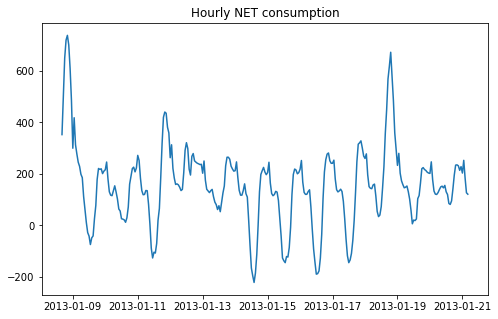

In [145]:
#pour la présentation:
fig = plt.figure(figsize=(8, 5))
plt.plot(df['Timestamp'].loc[4600:4900], df['NET'].loc[4600:4900])
plt.title("Hourly NET consumption")
plt.savefig("hourly_snapshot")
plt.show()

## Customer infos:

In [146]:
print(f"total installed capacity is: {cust_info['Generator Capacity'].sum()} kW")
print(f"average installed capacity is: {cust_info['Generator Capacity'].mean()} kW")

total installed capacity is: 504.99 kW
average installed capacity is: 1.6832999999999994 kW


## Temperature

In [147]:
temp = pd.read_csv("./data/Temperature.csv", header = 0)[24:]
temp = np.array(temp.AirTemp)
temp = np.append(temp,[temp[-1],temp[-1],temp[-1]])
temp


array([11.9, 12.8, 13.1, ..., 12.1, 12.1, 12.1])

In [148]:
%whos

Variable           Type                Data/Info
------------------------------------------------
AdvModel           type                <class 'docplex.mp.advmodel.AdvModel'>
BasicMicrogrid     type                <class '__main__.BasicMicrogrid'>
C_bat_dim          int                 0
C_grid             float64             207438.5312214378
E_bat              list                n=8760
Microgrid          type                <class '__main__.Microgrid'>
P_DR_dec           list                n=8760
P_DR_inc           list                n=8760
P_ch               list                n=8760
P_grid             list                n=8760
P_heat             list                n=8760
P_pv               list                n=8760
P_pv_dim           int                 0
P_pv_installed     float               504.9899999999998
T                  list                n=8760
T_out              ndarray             8760: 8760 elems, type `float64`, 70080 bytes
arams              dict           

In [149]:
del unstk
del cust_info 
del data_2013
del data_cust
del df_maxday
del fig
del meltdate

In [150]:
%whos

Variable           Type         Data/Info
-----------------------------------------
AdvModel           type         <class 'docplex.mp.advmodel.AdvModel'>
BasicMicrogrid     type         <class '__main__.BasicMicrogrid'>
C_bat_dim          int          0
C_grid             float64      207438.5312214378
E_bat              list         n=8760
Microgrid          type         <class '__main__.Microgrid'>
P_DR_dec           list         n=8760
P_DR_inc           list         n=8760
P_ch               list         n=8760
P_grid             list         n=8760
P_heat             list         n=8760
P_pv               list         n=8760
P_pv_dim           int          0
P_pv_installed     float        504.9899999999998
T                  list         n=8760
T_out              ndarray      8760: 8760 elems, type `float64`, 70080 bytes
arams              dict         n=8
baseline           ndarray      8760: 8760 elems, type `float64`, 70080 bytes
consumption        ndarray      8760: 8760 ele

# Model

In [164]:
class Microgrid : 
    
    def __init__(self, timestep, N_timesteps, interest_rate, **parameters):
        
        # Inputs: 
        #   timestep : duration of each timestep
        #   N_timesteps : the number of timesteps
        #   interest_rate : interest rate of the project for the actualization of costs
        #   **parameters : other parameters
        
        self.__timestep = timestep  
        self.__N_timesteps = N_timesteps
        self.__i = interest_rate
        self.__CRF = (self.__i * (1 + self.__i) ** 25) / ((1 + self.__i) ** 25 - 1)
        
        self.__c0 = parameters['c0'] # Coût d'accès au réseau
        
        self.__c1_FlexD = parameters['c1_FlexD'] # Prix des premiers 40 kwh pour le tarif flexD
        self.__c2_FlexD = parameters['c2_FlexD'] # Prix par la suite pour le tarif flexD
        self.__c_pointe_FlexD = parameters['c_pointe_FlexD'] # Prix lors de la pointe
        
        self.__c1_rec = parameters['c1_rec'] # Prix des premiers 40 kwh pour le tarif avec récompenses
        self.__c2_rec = parameters['c2_rec'] # Prix par la suite pour le tarif avec récompenses
        self.__B_rec = parameters['B_rec'] # Montant des récompenses lors des pointes
        
        self.__P_pv_installed = parameters['P_pv_installed'] # Puissance PV installé dans le microréseau de référence
        self.__P_pv_unit = parameters['P_pv_unit'] # Puissance d'un panneau PV
        self.__C_inv_PV = parameters["C_inv_PV"] # Cost of PV per kW
        
        self.__C_bat_unit = parameters['C_bat_unit'] # Capacité d'une batterie
        self.__eff_bat = parameters['eff_bat'] # efficacité de la batterie
        self.__P_bat_max = parameters['P_bat_max'] # puissance de charge et décharge maximale
        self.__C_inv_bat = parameters['C_inv_bat'] # Coût d'une batterie
        self.__CRF_bat = 1 + 1/(1+self.__i)**10 + 1/(1+self.__i)**20 # CAPEX de la batterie
        
        self.__R = parameters['R']
        self.__C = parameters['C']
        self.__alpha = math.exp(-1/(self.__R*self.__C))
        self.__eff_heat = parameters['eff_heat']
        self.__T_min = parameters['T_min']
        self.__T_max = parameters['T_max']
        self.__T_ref = parameters['T_ref']
        self.__Beta_heat = parameters['Beta_heat']
        
        
    def Optim(self, peaks, baseline, pricing_type, pv_generation, daily_DR, max_controlable_load, T_out,ref_DR,P_Hvac_ref):
        
        # Inputs: 
        #    Peaks : Moments des pointes
        #    baseline : Load (consommation + moyenne DR journalière)
        #    pricing_type : type de tarification "FlexD" ou "REC"
        #    pv_generation : production PV du microréseau de référence
        #    daily_DR : Total d'énergie déplacée dans une journée 
        #   
        # Output:
        #
        
        # Define the model
        model = AdvModel(name="microgrid")
        
        '''-------------- PV --------------'''
        
        # nombre de panneaux PV
        P_pv_dim = model.continuous_var(lb = 0,            
                                      ub = 100000, 
                                      name = 'P_pv_dim')
        
        #n_pv_dim = 1000
        
        # Puissance PV produite
        P_pv = model.continuous_var_list(self.__N_timesteps,
                                         lb = 0, 
                                         ub = 1000, 
                                         name = 'P_pv')
        
        # Puissance selon la production du microréseau
        model.add_constraints(P_pv[t] == P_pv_dim/self.__P_pv_installed * pv_generation[t] for t in range(self.__N_timesteps))
        
        
        '''-------------- STORAGE SYSTEM --------------'''
        
        # Capacité du système de stockage
        C_bat_dim = model.continuous_var(lb = 0, 
                                      ub = 10000, 
                                      name = 'C_bat_dim')
        
        # État de charge dans la batterie
        E_bat = model.continuous_var_list(self.__N_timesteps,
                                         lb = 0, 
                                         ub = 10000, 
                                         name = 'E_bat')
        
        # Puissance de charge ou décharge dans la batterie (+ charge, - décharge)
        P_ch = model.continuous_var_list(self.__N_timesteps,
                                         lb = -10000, 
                                         ub = 10000, 
                                         name = 'P_ch')
        
        # Fonction piecewise pour gérer la charge et décharge
        charge = model.piecewise(preslope=1/self.__eff_bat, breaksxy=[(0,0)], postslope=self.__eff_bat) 
        
        # État de charge < capacité de la batterie
        model.add_constraints(E_bat[t] <= C_bat_dim for t in range(self.__N_timesteps))
        
        # Limites de puissance
        model.add_constraints(P_ch[t] <= 0.5 * C_bat_dim for t in range(self.__N_timesteps))
        model.add_constraints(P_ch[t] >= -0.5 * C_bat_dim for t in range(self.__N_timesteps))
        
        # Batterie vide au début
        model.add_constraint(E_bat[0] == 0)
        
        # Équilibre de la batterie
        model.add_constraints(E_bat[t] == E_bat[t-1] + charge(P_ch[t]) for t in range(self.__N_timesteps))
        
        '''-------------- DEMANDE RESPONSE --------------'''
        
        # Augmentation de la demande
        P_DR_inc = model.continuous_var_list(self.__N_timesteps,
                                         lb = 0, 
                                         ub = 10000, 
                                         name = 'P_DR_inc')
        
        # Diminution de la demande
        P_DR_dec = model.continuous_var_list(self.__N_timesteps,
                                         lb = 0, 
                                         ub = 10000, 
                                         name = 'P_DR_dec')
        
        # Demande après DR
        P_DR = model.continuous_var_list(self.__N_timesteps,
                                         lb = 0, 
                                         ub = 10000, 
                                         name = 'P_DR')
        
        # Calcul de P_DR
        model.add_constraints(P_DR[t] == baseline[t] + P_DR_inc[t] - P_DR_dec[t] for t in range(self.__N_timesteps))
        model.add_constraints(P_DR[t] == baseline[t] + P_DR_inc[t] - P_DR_dec[t] for t in range(self.__N_timesteps))
        # Maximum horaire
        model.add_constraints(P_DR_inc[t] <= max_controlable_load[t] for t in range(self.__N_timesteps))
        model.add_constraints(P_DR_dec[t] <= max_controlable_load[t] for t in range(self.__N_timesteps))
        # Maximum quotidien
        model.add_constraints(sum([P_DR_inc[j] for j in range(i*24,i*24+24)]) == sum([P_DR_dec[j] for j in range(i*24,i*24+24)]) for i in range(365))
        model.add_constraints(sum([P_DR_inc[j] for j in range(i*24,i*24+24)]) <= daily_DR[i] for i in range(365))
        
        '''-------------- HVAC --------------'''
        
        # Température intérieure
        T = model.continuous_var_list(self.__N_timesteps,
                                         lb = 0, 
                                         ub = 100, 
                                         name = 'T')
        
        # Puissance de chauffage (+) et climatisation (-)
        P_heat = model.continuous_var_list(self.__N_timesteps,
                                         lb = -10000, 
                                         ub = 10000, 
                                         name = 'P_heat')
        
        # fonction piecewise pour gérer chauffage/climatisation
        #heat = model.piecewise(preslope=self.__R/(300*self.__eff_heat), breaksxy=[(0,0)], postslope = self.__R*self.__eff_heat/300) 
        
        # Température initiale
        model.add_constraint(T[0] == 20)
        model.add_constraints(T[t] <= self.__T_max for t in range(self.__N_timesteps))
        model.add_constraints(T[t] >= self.__T_min for t in range(self.__N_timesteps))
        
        # Équilibre
        model.add_constraints(T[t] == self.__alpha * T[t-1] + (1-self.__alpha) * (T_out[t] + self.__R*self.__eff_heat/300*P_heat[t]) for t in range(self.__N_timesteps))
        
        
        
        '''-------------- GRID --------------'''
        
        # Puissance à acheter
        P_grid = model.continuous_var_list(self.__N_timesteps, 
                                          lb = -10000, 
                                          ub = 10000, 
                                          name = 'P_grid')
        
        # Fonction pour P_heat
        absolu = model.piecewise(preslope=-1, breaksxy=[(0,0)], postslope = 1) 
        
        # Équilibre
        model.add_constraints(P_grid[t] + P_pv[t] - P_ch[t] == P_DR[t] + absolu(P_heat[t]) for t in range(self.__N_timesteps))
        
        #Mesurage net sur l'année
        model.add_constraint(sum(P_grid)>=0)
        
        # Grid cost
        if pricing_type == 'FlexD' : 
            
            # Tarification FlexD
            price_FlexD = model.piecewise(preslope=0, breaksxy=[(0,300*self.__c0), (300*40, 300*40*self.__c1_FlexD+300*self.__c0)], postslope=self.__c2_FlexD) 
        
            C_grid = 0
            for i in range(365):
                P_grid_day = sum([P_grid[j] for j in range(i*24,i*24+24)]) # Puissance consommée
                P_grid_peak = sum([P_grid[j] for j in range(i*24,i*24+24) if peaks[j] == True]) # Puissance consommée en pointe
                C_grid += price_FlexD(P_grid_day) + self.__c_pointe_FlexD * P_grid_peak 
                
        else : 
            
            # Tarification avec récompenses
            price_Rec = model.piecewise(preslope=0, breaksxy=[(0,300*self.__c0), (300*40, 300*40*self.__c1_rec+300*self.__c0)], postslope=self.__c2_rec) 
            valPositive = model.piecewise(preslope=0, breaksxy=[(0,0)], postslope = 1)
            C_grid = 0
            for i in range(365):
                P_grid_day = sum([P_grid[j] for j in range(i*24,i*24+24)]) # Puissance consommée
                P_rec = sum([baseline[j]+DR_ref[j]+P_Hvac_ref[j]- P_grid[j] for j in range(i*24,i*24+24) if peaks[j] == True]) # Puissance consommée en pointe
                C_grid += price_Rec(P_grid_day) - self.__B_rec *  valPositive(P_rec)
                
        '''-------------- Pénalité Temp --------------'''
        C_temp=0
        for t in range (self.__N_timesteps):
            C_temp+=absolu(self.__T_ref - T[t])
                
        '''-------------- OBJECTIVE --------------'''
        
        
        OPEX = C_grid + self.__Beta_heat * C_temp
        CAPEX = self.__CRF * (self.__C_inv_PV * P_pv_dim + C_bat_dim * self.__C_inv_bat * self.__CRF_bat) 
        MTN = 0.01 * self.__C_inv_PV * P_pv_dim + 6.25 * C_bat_dim 
        
        obj = OPEX + CAPEX + MTN
        
        '''-------------- SOLVING THE MODEL --------------'''
        
        model.minimize(obj)
        solution = model.solve()
        
        C_grid = solution.get_value(C_grid)
        P_pv_dim = solution.get_value(P_pv_dim)
        C_bat_dim = solution.get_value(C_bat_dim)
        P_DR_inc = solution.get_values(P_DR_inc)
        P_DR_dec = solution.get_values(P_DR_dec)
        P_grid = solution.get_values(P_grid)
        P_pv = solution.get_values(P_pv)
        P_ch = solution.get_values(P_ch)
        E_bat = solution.get_values(E_bat)
        P_heat = solution.get_values(P_heat)
        T = solution.get_values(T)
        
        return C_grid, P_pv_dim, C_bat_dim, P_DR_inc, P_DR_dec, P_grid, P_pv, P_ch, E_bat, P_heat, T

    

# Modelèle de référence

In [155]:
class BasicMicrogrid : 
    
    def __init__(self, timestep, N_timesteps, **parameters):
        
        # Inputs: 
        #   timestep : duration of each timestep
        #   N_timesteps : the number of timesteps
        #   interest_rate : interest rate of the project for the actualization of costs
        #   **parameters : other parameters
        
        self.__timestep = timestep  
        self.__N_timesteps = N_timesteps
        
        self.__c0 = parameters['c0'] # Coût d'accès au réseau
        
        self.__c1 = parameters['c1'] # Prix des premiers 40 kwh pour le tarif avec récompenses
        self.__c2 = parameters['c2'] # Prix par la suite pour le tarif avec récompenses
        
        self.__R = parameters['R']
        self.__C = parameters['C']
        self.__alpha = math.exp(-1/(self.__R*self.__C))
        self.__eff_heat = parameters['eff_heat']
        self.__T_ref = parameters['T_ref']
        self.__Beta_heat = parameters['Beta_heat']
        
        
    def Optim(self, baseline, T_out):
        
        # Inputs: 
        #    baseline : Load (consommation + moyenne DR journalière)
        #    T_out: température extérieure
        #   
        # Output:
        #
        
        # Define the model
        model = AdvModel(name="microgrid")
        
        '''-------------- HVAC --------------'''
    
        
        # Puissance de chauffage (+) et climatisation (-)
        P_heat = model.continuous_var_list(self.__N_timesteps,
                                         lb = -10000, 
                                         ub = 10000, 
                                         name = 'P_heat')
        
        
        # Équilibre
        model.add_constraints(self.__T_ref == self.__alpha * self.__T_ref + (1-self.__alpha) * (T_out[t] + self.__R*self.__eff_heat/300*P_heat[t]) for t in range(self.__N_timesteps))
        
        
        
        '''-------------- GRID --------------'''
        
        # Puissance à acheter
        P_grid = model.continuous_var_list(self.__N_timesteps, 
                                          lb = 0, 
                                          ub = 10000, 
                                          name = 'P_grid')
        
        # Fonction pour P_heat
        absolu = model.piecewise(preslope=-1, breaksxy=[(0,0)], postslope = 1) 
        
        # Équilibre
        model.add_constraints(P_grid[t] == baseline[t] + absolu(P_heat[t]) for t in range(self.__N_timesteps))
        
        
        
        # Tarification avec récompenses
        price = model.piecewise(preslope=0, breaksxy=[(0,300*self.__c0), (300*40, 300*40*self.__c1+300*self.__c0)], postslope=self.__c2) 
        
        C_grid = 0
        for i in range(365):
            P_grid_day = sum([P_grid[j] for j in range(i*24,i*24+24)]) # Puissance consommée
            P_rec = sum([baseline[j] - P_grid[j] for j in range(i*24,i*24+24)]) # Puissance consommée en pointe
            C_grid += price(P_grid_day)
                
                
        '''-------------- OBJECTIVE --------------'''
    
        obj = C_grid
        
        '''-------------- SOLVING THE MODEL --------------'''
        
        model.minimize(obj)
        solution = model.solve()
        
        C_grid = solution.get_value(C_grid)
        P_grid = solution.get_values(P_grid)
        P_heat = solution.get_values(P_heat)
        
        return  C_grid, P_grid, P_heat

# Résolution modèle de référence

In [168]:
params = {'c0': 0.42238,
         'c1': 0.06319,
         'c2': 0.09749,
         'R': 0.0180/0.001,
         'C' : 2.77778e-7*295585.31,
         'eff_heat' : 1,
         'T_ref': 21,
         'Beta_heat' : 8,}

rate = 0.08

baseline_model = BasicMicrogrid(timestep = 1, 
                N_timesteps = len(df),  
                **params)

baseline = np.array(df['BASELINE']+df['AVERAGE_CONTROLABLE_LOAD'])
T_out = temp

C_grid_ref, P_grid_ref, P_heat_ref = baseline_model.Optim(baseline, T_out)
C_grid_ref

226319.192934968

# Résolution Modèle Récompense

In [165]:
params = {'c0': 0.42238,
         'c1_FlexD': 0.04449,
         'c2_FlexD': 0.07650,
         'c_pointe_FlexD': 0.51967,
         'c1_rec': 0.06319,
         'c2_rec': 0.09749,
         'B_rec': 0.55,
         'P_pv_installed' : P_pv_installed,
         'C_inv_PV' : 1179.94,
         'P_pv_unit' : 0.370,
         'C_bat_unit': 232,
         'eff_bat': 0.895,
         'P_bat_max': 130,
         'C_inv_bat': 132, #prix minimum pour avoir des batteries : 50$
         'R': 0.0180/0.001,
         'C' : 2.77778e-7*295585.31,
         'eff_heat' : 1,
         'T_min' : 18,
         'T_max': 24,
         'T_ref': 21,
         'Beta_heat' : 8,}

rate = 0.08

test = Microgrid(timestep = 1, 
                N_timesteps = len(df),  
                interest_rate = rate,
                **params)

consumption = np.array(df['TOTAL'])
peaks = np.array(df['PEAK'])
baseline = np.array(df['BASELINE'])
DR_ref=np.array(df['AVERAGE_CONTROLABLE_LOAD'])
pv = np.array(df['GG'])
daily_DR = np.array(daily_CL)
controlable_load = np.array(df['MAX_CONTROLABLE_LOAD'])
T_out = temp

C_grid_rec, P_pv_dim_rec, C_bat_dim_rec, P_DR_inc, P_DR_dec, P_grid, P_pv, P_ch, E_bat, P_heat, T = test.Optim(peaks, baseline, 'REC', pv, daily_DR, controlable_load, T_out,DR_ref,np.array(P_heat_ref) )

In [166]:
C_grid_rec, P_pv_dim_rec, C_bat_dim_rec

(194484.48561047085, 0, 0)

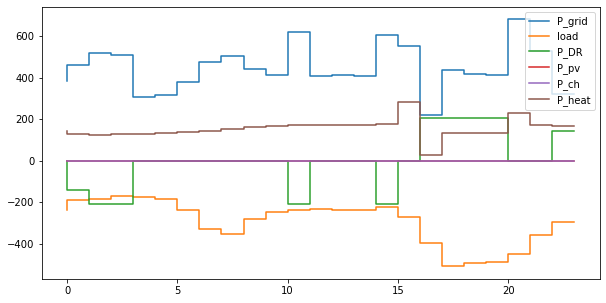

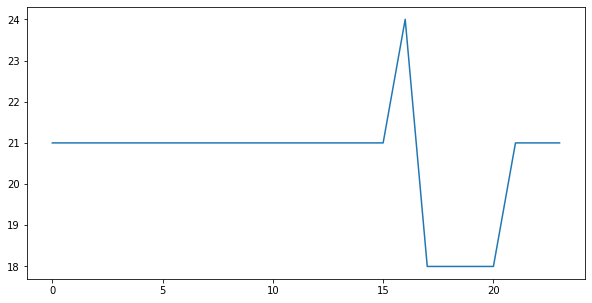

In [167]:
start = 8496
end = 8520
l = end-start


plt.rcParams['figure.figsize'] = [10, 5]
plt.step(range(l),P_grid[start:end], label = 'P_grid')
plt.step(range(l),-np.ones(l)*baseline[start:end], label = 'load')
plt.step(range(l),P_DR_dec[start:end]-np.ones(l)*P_DR_inc[start:end], label = 'P_DR')
plt.step(range(l),P_pv[start:end], label = 'P_pv')
plt.step(range(l),-np.ones(l)*P_ch[start:end], label = 'P_ch')
plt.step(range(l),np.absolute(P_heat[start:end]), label = 'P_heat')

plt.legend()
plt.show()

plt.plot(range(l),T[start:end])
plt.show()


# Résolution Modèle Flex D

In [169]:
params = {'c0': 0.42238,
         'c1_FlexD': 0.04449,
         'c2_FlexD': 0.07650,
         'c_pointe_FlexD': 0.51967,
         'c1_rec': 0.06319,
         'c2_rec': 0.09749,
         'B_rec': 0.55,
         'P_pv_installed' : P_pv_installed,
         'C_inv_PV' : 1179.94,
         'P_pv_unit' : 0.370,
         'C_bat_unit': 232,
         'eff_bat': 0.895,
         'P_bat_max': 130,
         'C_inv_bat': 132, #prix minimum pour avoir des batteries : 50$
         'R': 0.0180/0.001,
         'C' : 2.77778e-7*295585.31,
         'eff_heat' : 1,
         'T_min' : 18,
         'T_max': 24,
         'T_ref': 21,
         'Beta_heat' : 8,}

rate = 0.08

test = Microgrid(timestep = 1, 
                N_timesteps = len(df),  
                interest_rate = rate,
                **params)

consumption = np.array(df['TOTAL'])
peaks = np.array(df['PEAK'])
baseline = np.array(df['BASELINE'])
DR_ref=np.array(df['AVERAGE_CONTROLABLE_LOAD'])
pv = np.array(df['GG'])
daily_DR = np.array(daily_CL)
controlable_load = np.array(df['MAX_CONTROLABLE_LOAD'])
T_out = temp

C_grid_flex, P_pv_dim_flex, C_bat_dim_flex, P_DR_inc, P_DR_dec, P_grid, P_pv, P_ch, E_bat, P_heat, T = test.Optim(peaks, baseline, 'FlexD', pv, daily_DR, controlable_load, T_out,DR_ref,np.array(P_heat_ref) )

In [171]:
C_grid_flex, P_pv_dim_flex, C_bat_dim_flex

(190241.99085937292, 0, 0)

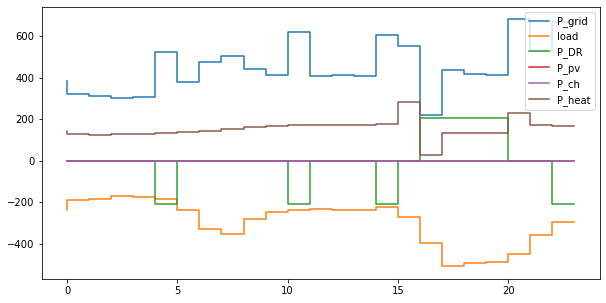

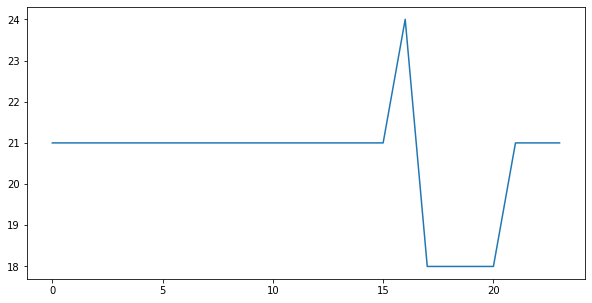

In [172]:
start = 8496
end = 8520
l = end-start


plt.rcParams['figure.figsize'] = [10, 5]
plt.step(range(l),P_grid[start:end], label = 'P_grid')
plt.step(range(l),-np.ones(l)*baseline[start:end], label = 'load')
plt.step(range(l),P_DR_dec[start:end]-np.ones(l)*P_DR_inc[start:end], label = 'P_DR')
plt.step(range(l),P_pv[start:end], label = 'P_pv')
plt.step(range(l),-np.ones(l)*P_ch[start:end], label = 'P_ch')
plt.step(range(l),np.absolute(P_heat[start:end]), label = 'P_heat')

plt.legend()
plt.show()

plt.plot(range(l),T[start:end])
plt.show()